# Analysis of Cross-Species Interactions

Lorem ipsum...

In [24]:
from itertools import combinations, product
from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd
from Bio import SeqIO
from loguru import logger
from tqdm import tqdm

from philharmonic.utils import filter_proteins_GO, plot_degree

## Run Localization Prediction

In [2]:
pdam_sequence_path = (
    "/mnt/home/ssledzieski/database/philharmonic/p_damicornis/pdam_proteins.fasta"
)
symb_sequence_path = (
    "/mnt/home/ssledzieski/database/philharmonic/c_goreaui/SymbC1.Gene_Models.50.800.fa"
)

pdam_loc_path = "/mnt/home/ssledzieski/database/philharmonic/p_damicornis/pdam_localization_results_20240130-084830.csv"
symb_loc_path = "/mnt/home/ssledzieski/database/philharmonic/c_goreaui/cgor_localization_results_20240130-092714.csv"

We use [`deeploc2`](https://academic.oup.com/nar/article/50/W1/W228/6576357) to predict localization of proteins from *P. damicornis* and *C. goreaui*b

In [28]:
!echo "$ export CUDA_VISIBLE_DEVICES=1; deeploc2 -f {pdam_sequence_path} -o {pdam_loc_path} -m Accurate -p -d cuda"
!echo "$ export CUDA_VISIBLE_DEVICES=2; deeploc2 -f {symb_sequence_path} -o {symb_loc_path} -m Accurate -p -d cuda"

$ export CUDA_VISIBLE_DEVICES=1; deeploc2 -f /mnt/home/ssledzieski/database/philharmonic/p_damicornis/pdam_proteins.fasta -o /mnt/home/ssledzieski/database/philharmonic/p_damicornis/pdam_localization_results_20240130-084830.csv -m Accurate -p -d cuda
$ export CUDA_VISIBLE_DEVICES=2; deeploc2 -f /mnt/home/ssledzieski/database/philharmonic/c_goreaui/SymbC1.Gene_Models.50.800.fa -o /mnt/home/ssledzieski/database/philharmonic/c_goreaui/cgor_localization_results_20240130-092714.csv -m Accurate -p -d cuda


## Extract Membrane & Related Proteins

In [4]:
pdam_out_path = "/mnt/home/ssledzieski/database/philharmonic/p_damicornis/pdam_membrane_proteins.csv"
symb_out_path = (
    "/mnt/home/ssledzieski/database/philharmonic/c_goreaui/cgor_membrane_proteins.csv"
)
joint_sequence_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/x_species/pdamxsymb_proteins.fasta"

In [5]:
pdam_allowed_locations = ["Cell membrane", "Lysosome/Vacuole"]
symb_allowed_locations = ["Cell membrane", "Extracellular"]

In [6]:
pdam_loc = pd.read_csv(pdam_loc_path)
symb_loc = pd.read_csv(symb_loc_path)

In [7]:
pdam_membrane = pdam_loc[
    pdam_loc["Localizations"].str.contains("|".join(pdam_allowed_locations))
]
symb_membrane = symb_loc[
    symb_loc["Localizations"].str.contains("|".join(symb_allowed_locations))
]
logger.info(f"P. damicornis membrane proteins: {pdam_membrane.shape[0]}")
logger.info(f"C. goreaui membrane proteins: {symb_membrane.shape[0]}")

2024-09-30 10:06:31.503 | INFO     | __main__:<module>:7 - P. damicornis membrane proteins: 4753
2024-09-30 10:06:31.504 | INFO     | __main__:<module>:8 - C. goreaui membrane proteins: 5336


In [8]:
pdam_sequences = SeqIO.to_dict(SeqIO.parse(pdam_sequence_path, "fasta"))
symb_sequences = SeqIO.to_dict(SeqIO.parse(symb_sequence_path, "fasta"))
all_sequences = {**pdam_sequences, **symb_sequences}
membrane_sequences = {
    k: v
    for k, v in all_sequences.items()
    if k in pdam_membrane["Protein_ID"].values
    or k in symb_membrane["Protein_ID"].values
}
logger.info(f"Membrane proteins: {len(membrane_sequences)}")

2024-09-30 10:06:37.627 | INFO     | __main__:<module>:5 - Membrane proteins: 9117


In [9]:
pdam_membrane.to_csv(pdam_out_path, sep="\t", index=False)
symb_membrane.to_csv(symb_out_path, sep="\t", index=False)
SeqIO.write(membrane_sequences.values(), joint_sequence_path, "fasta")

9117

---

## Generate Candidates

In [29]:
pdam_go_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"
symb_go_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/20240926_cgoreaui_GO_map.csv"
go_database_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"
go_filter_path = "/mnt/home/ssledzieski/GitHub/philharmonic/assets/go_filter.txt"

candidates_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/x_species/pdamxsymb_candidates.tsv"

In [11]:
pdam_filtered = filter_proteins_GO(
    pdam_membrane["Protein_ID"], pdam_go_path, go_database_path, go_filter_path
)
symb_filtered = filter_proteins_GO(
    symb_membrane["Protein_ID"], symb_go_path, go_database_path, go_filter_path
)
logger.info(f"P. damicornis filtered proteins: {len(pdam_filtered)}")
logger.info(f"C. goreaui filtered proteins: {len(symb_filtered)}")

2024-09-30 10:06:39.584 | INFO     | __main__:<module>:3 - P. damicornis filtered proteins: 3413
2024-09-30 10:06:39.585 | INFO     | __main__:<module>:4 - C. goreaui filtered proteins: 1535


In [12]:
with open(candidates_path, "w+") as f:
    i = 0
    for pdam_protein, symb_protein in product(pdam_filtered, symb_filtered):
        i += 1
        f.write(f"{pdam_protein}\t{symb_protein}\n")
logger.info(f"Total number of candidates: {i}")

2024-09-30 10:06:40.632 | INFO     | __main__:<module>:6 - Total number of candidates: 5238955


---

## Predict Cross-Species Network

We likewise use D-SCRIPT to predict cross-species interactions.

In [13]:
predictions_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/x_species/pdamxsymb_predictions"

In [27]:
!echo "$ dscript predict --model samsl/dscript_human_v1 --seqs {joint_sequence_path}  --outfile {predictions_path} --pairs {candidates_path} --device 0"

$ dscript predict --model samsl/dscript_human_v1 --seqs /mnt/home/ssledzieski/Projects/philharmonic-experiments/results/x_species/pdamxsymb_proteins.fasta  --outfile /mnt/home/ssledzieski/Projects/philharmonic-experiments/results/x_species/pdamxsymb_predictions --pairs /mnt/home/ssledzieski/Projects/philharmonic-experiments/results/x_species/pdamxsymb_candidates.tsv --device 0


---

## Construct Co-interaction Networks

In [22]:
pdam_cointeraction_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/x_species/pdam_membrane_xspecies_coneighbor.tsv"
symb_cointeraction_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/x_species/symb_membrane_xspecies_coneighbor.tsv"

In [15]:
edgelist = pd.read_csv(f"{predictions_path}.positive.tsv", sep="\t", header=None)
edgelist.columns = ["source", "target", "weight"]
full_G = nx.from_pandas_edgelist(edgelist, edge_attr=["weight"])

In [16]:
pdam_prots_l = sorted(list(pdam_filtered.intersection(full_G.nodes())))
pdam_pairwise = np.zeros((len(pdam_prots_l), len(pdam_prots_l)))
combin = list(combinations(pdam_prots_l, 2))

for p1, p2 in tqdm(combin, total=len(combin)):
    p1_neighbors = set(nx.neighbors(full_G, p1))
    p2_neighbors = set(nx.neighbors(full_G, p2))
    p1_i = pdam_prots_l.index(p1)
    p2_i = pdam_prots_l.index(p2)
    pdam_pairwise[p1_i, p2_i] = len(p1_neighbors.intersection(p2_neighbors))

100%|██████████| 1826916/1826916 [00:31<00:00, 58533.48it/s]


In [17]:
symb_prots_l = sorted(list(symb_filtered.intersection(full_G.nodes())))
symb_pairwise = np.zeros((len(symb_prots_l), len(symb_prots_l)))
symb_combin = list(combinations(symb_prots_l, 2))


for p1, p2 in tqdm(symb_combin, total=len(symb_combin)):
    p1_neighbors = set(nx.neighbors(full_G, p1))
    p2_neighbors = set(nx.neighbors(full_G, p2))
    p1_i = symb_prots_l.index(p1)
    p2_i = symb_prots_l.index(p2)
    symb_pairwise[p1_i, p2_i] = len(p1_neighbors.intersection(p2_neighbors))

  0%|          | 0/280875 [00:00<?, ?it/s]

100%|██████████| 280875/280875 [00:02<00:00, 125793.45it/s]


In [18]:
pdam_coneighbor_graph = nx.from_pandas_adjacency(
    pd.DataFrame(pdam_pairwise, columns=pdam_prots_l, index=pdam_prots_l)
)
symb_coneighbor_graph = nx.from_pandas_adjacency(
    pd.DataFrame(symb_pairwise, columns=symb_prots_l, index=symb_prots_l)
)
pdam_coneighbor_graph.remove_nodes_from(list(nx.isolates(pdam_coneighbor_graph)))
symb_coneighbor_graph.remove_nodes_from(list(nx.isolates(symb_coneighbor_graph)))

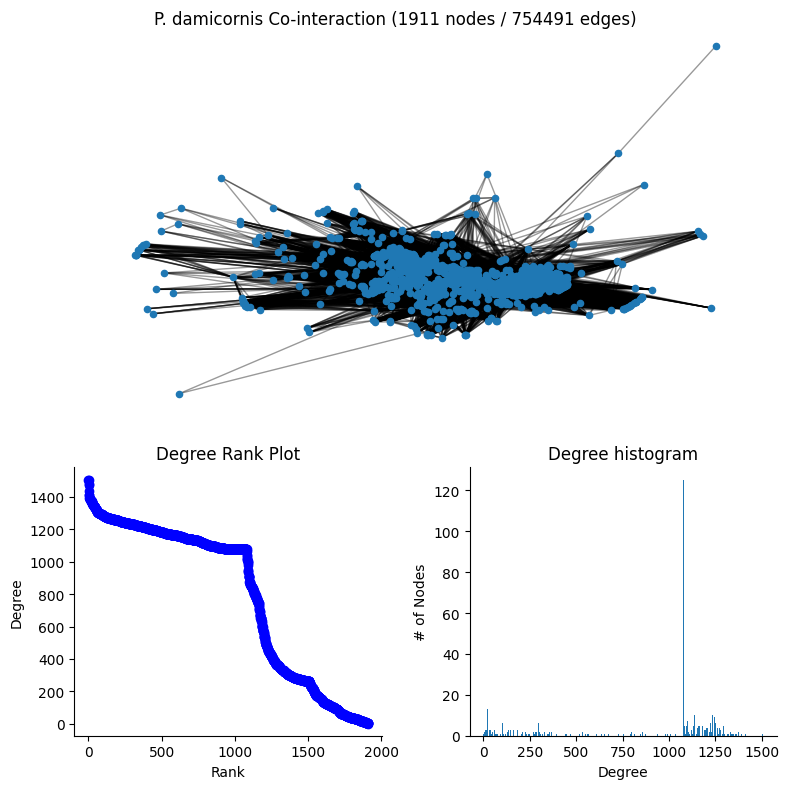

In [25]:
plot_degree(
    pdam_coneighbor_graph,
    "P. damicornis Co-interaction",
    savefig=Path(pdam_cointeraction_path).with_suffix(".png"),
)

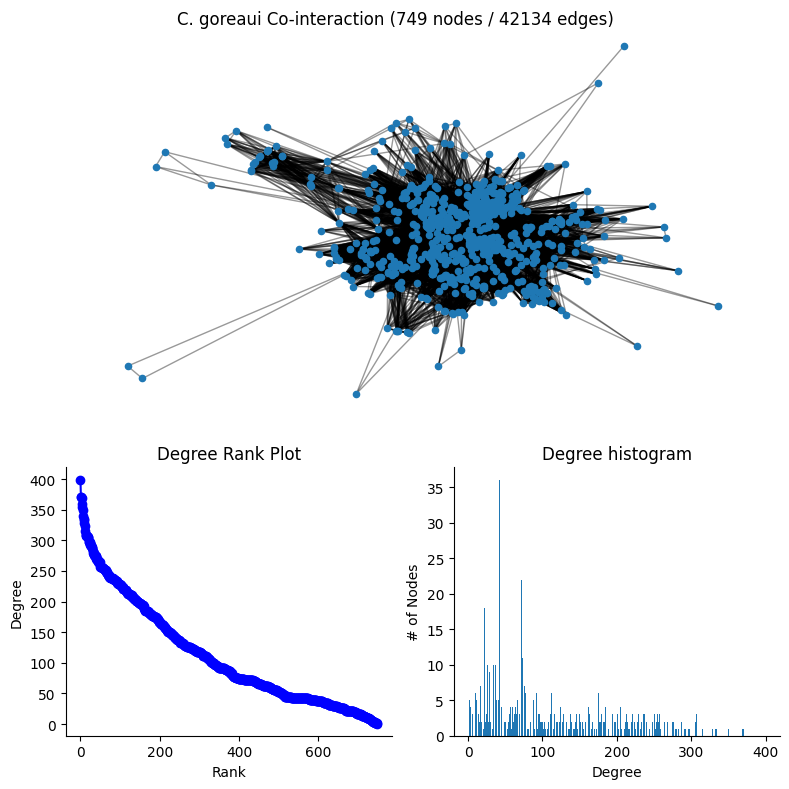

In [26]:
plot_degree(
    symb_coneighbor_graph,
    "C. goreaui Co-interaction",
    savefig=Path(symb_cointeraction_path).with_suffix(".png"),
)

In [23]:
nx.to_pandas_edgelist(pdam_coneighbor_graph).to_csv(
    pdam_cointeraction_path, sep="\t", header=False, index=False
)
nx.to_pandas_edgelist(symb_coneighbor_graph).to_csv(
    symb_cointeraction_path, sep="\t", header=False, index=False
)